In [2]:
import os
import numpy as np
import itertools
import time
import random
from collections import OrderedDict, Counter, defaultdict
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

import copy
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import random_split

import math
import json
from typing import Callable, Iterable, Tuple
from torch.optim import Optimizer
from torch.utils.data import WeightedRandomSampler

import wandb
wandb.login()
from pytorch_lightning.loggers import WandbLogger

import collections

wandb: Currently logged in as: chucooleg (use `wandb login --relogin` to force relogin)


## Data -- Generation

In [8]:
def generate_cards(attributes, attr_order, num_attributes, num_attr_vals):
    
    attr_order = attr_order[:num_attributes]
    attributes = {att_k:attributes[att_k][:num_attr_vals] for att_k in attributes if att_k in attr_order}
    
    cards = []
    idx_to_card = {}
    card_to_idx = {}

    i = 0
    attr_vals = [attributes[attr] for attr in attr_order]
    for combo in itertools.product(*attr_vals):
        card = tuple(combo)
        cards.append(card)
        card_to_idx[card] = i
        idx_to_card[i] = card
        i += 1
    
    assert len(cards) == len(set(cards))
    print(f'Generated {len(cards)} unqiue cards')                
    return cards, idx_to_card, card_to_idx


def num_shared_attributes(card1, card2):
    matching_concepts = tuple(s1 if s1==s2 else '-' for s1,s2 in zip(card1,card2))
    num_matching_concepts = len([c for c in matching_concepts if c != '-'])
    return matching_concepts, num_matching_concepts


def generate_card_pairs(cards, card_to_idx):
    '''
    find all combos of cards, filter down to the ones that share concepts.
    '''
    cardpairs_with_shared_concepts = []
    cardpairs_without_shared_concepts = []

    cardpair_to_idx, idx_to_cardpair, idx = {}, {}, 0
    num_matching_concepts_all = {}
    for card1, card2 in itertools.combinations(cards,2):
        if card1 != card2:
            matching_concepts, num_matching_concepts = num_shared_attributes(card1, card2)
            num_matching_concepts_all[(card1, card2)] = num_matching_concepts
            if num_matching_concepts:
                cardpairs_with_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            else:
                cardpairs_without_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            idx_to_cardpair[idx] = (card_to_idx[card1], card_to_idx[card2])
            cardpair_to_idx[(card_to_idx[card1], card_to_idx[card2])] = idx
            idx += 1
    print(f'Generated {len(cardpairs_with_shared_concepts) + len(cardpairs_without_shared_concepts)} cardpairs')
    print(f'-- {len(cardpairs_with_shared_concepts)} cardpairs with shared concept')
    print(f'-- {len(cardpairs_without_shared_concepts)} cardpairs without shared concept')
    print(Counter(num_matching_concepts_all.values()).most_common())
    return cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair


def match_concept_to_card(concept, card):
    '''
    Given a concept, determine if card matches.
    
    Arguments:
        concept: ('red', 'void', '-', '-')
        card: ex1. ('red', 'void', 'triangle', 'XOX')
              ex2. ('green', 'void', 'square', 'OXX')
    Returns:
        match: bool. ex1. True,
                     ex2. False
    '''
    match = 0
    for ct, cd in zip(concept, card):
        # As long as one concept matches, it is a match!
        if ct == cd:
            match += 1
    return match


def default_to_regular(d):
    if isinstance(d, defaultdict):
        d = {k: default_to_regular(v) for k, v in d.items()}
    return d

def gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=100, debug=False):
    
    # all cards
    cards, idx_to_card, card_to_idx = generate_cards(attributes, attr_order, num_attributes, num_attr_vals)
    # all card pairs
    cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair = \
        generate_card_pairs(cards, card_to_idx)
    
    # generate answers
    all_matches = []
    number_of_shared_concepts_per_match = []
    cardpair_to_matches = defaultdict(lambda : defaultdict(int))
#     for cardpair in cardpairs_with_shared_concepts + cardpairs_without_shared_concepts: # NOTE!!
    for cardpair in cardpairs_with_shared_concepts:
        shared_concept = cardpair[1]
        # look for all matching cards
        # ((card pair query), matching card)
        for card in cards:
            num_matched_concepts = match_concept_to_card(shared_concept, card)
            if num_matched_concepts:
                all_matches.append((cardpair_to_idx[cardpair[0]], card_to_idx[card]))
                cardpair_to_matches[cardpair_to_idx[cardpair[0]]][card_to_idx[card]] = num_matched_concepts
                number_of_shared_concepts_per_match.append(num_matched_concepts)
    cardpair_to_matches = default_to_regular(cardpair_to_matches)
    print('Total number of matches = ', len(all_matches))
    print('Number of shared concepts per match = ', Counter(number_of_shared_concepts_per_match).most_common())
    
    # hold out some cardpairs
    unseen_cardpair_indices = list(np.random.choice(len(cardpair_to_idx), size=num_unseen_cardpairs, replace=False))
    train_cardpair_indices = [idx for idx in range(len(cardpair_to_idx)) if idx not in unseen_cardpair_indices]
    assert len(set(unseen_cardpair_indices) | set(train_cardpair_indices)) == len(cardpair_to_idx)
    
    data = {
        'idx_to_key': idx_to_card,
        'key_to_idx': card_to_idx,
        'query_to_idx': cardpair_to_idx, 
        'idx_to_query': idx_to_cardpair,
        'all_matches': all_matches, # list of tuples (query idx, answer card)
        'query_to_keys': cardpair_to_matches, # lookup query idx:{'card1':num matched concepts, 'card2':num matched concepts,...}
        'unseen_query_indices': unseen_cardpair_indices,
        'seen_query_indices': train_cardpair_indices
    }
    return data


attributes = {
    'color': ['red', 'green', 'blue', 'orange', 'cyan', 'magenta', 'black', 'yellow'],
    'fill': ['void', 'dashed', 'solid', 'checkered', 'dotted', 'mosaic', 'noise', 'brushed'],
    'shape': ['square', 'circle', 'triangle', 'star', 'hexagon', 'pentagon', 'ellipse', 'rectangle'],
    'config': ['OOO', 'OOX', 'OXO', 'OXX', 'XOO', 'XOX', 'XXO', 'XXX']
}

attr_order = ['color', 'fill', 'shape', 'config']

num_attributes = 4
num_attr_vals = 3
game_data = gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)

Generated 81 unqiue cards
Generated 3240 cardpairs
-- 2592 cardpairs with shared concept
-- 648 cardpairs without shared concept
[(1, 1296), (2, 972), (0, 648), (3, 324)]
Total number of matches =  97200
Number of shared concepts per match =  [(1, 81648), (2, 14580), (3, 972)]


## Data -- Distribution, Splits

In [9]:
distribution_epsilon = 1e-100

count_table = np.zeros((len(game_data['idx_to_key']), len(game_data['idx_to_query'])))
        
for q, k in game_data['all_matches']:
    count_table[k, q] += 1    
        
xy = count_table/np.sum(count_table)
xy += distribution_epsilon
xy /= np.sum(xy)

x = np.sum(xy,0)
y = np.sum(xy,1)
xyind = y[None].T @ x[None]

In [10]:
# + 0.1
[(0.0029940119760479044, 270), (0.003548458638278998, 54)]
# + nothing
Counter(list(xy.reshape(-1))).most_common()

[(1.0000000000000003e-100, 165240), (1.0288065843621402e-05, 97200)]

In [11]:
np.sum(count_table)

97200.0

In [12]:
xy_rank = np.linalg.matrix_rank(xy)
print('xy_rank=',xy_rank)

xy_div_xyind_rank = np.linalg.matrix_rank((xy/xyind))
print('xy_div_xyind_rank=',xy_div_xyind_rank)

xy_rank= 65
xy_div_xyind_rank= 65


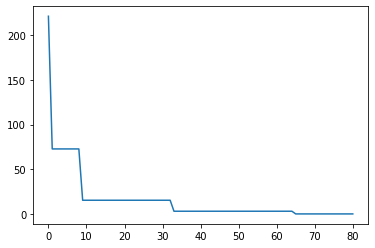

In [13]:
u, s, vh = np.linalg.svd(count_table)
plt.plot(s)

In [14]:
s

array([2.21269067e+02, 7.27461339e+01, 7.27461339e+01, 7.27461339e+01,
       7.27461339e+01, 7.27461339e+01, 7.27461339e+01, 7.27461339e+01,
       7.27461339e+01, 1.52970585e+01, 1.52970585e+01, 1.52970585e+01,
       1.52970585e+01, 1.52970585e+01, 1.52970585e+01, 1.52970585e+01,
       1.52970585e+01, 1.52970585e+01, 1.52970585e+01, 1.52970585e+01,
       1.52970585e+01, 1.52970585e+01, 1.52970585e+01, 1.52970585e+01,
       1.52970585e+01, 1.52970585e+01, 1.52970585e+01, 1.52970585e+01,
       1.52970585e+01, 1.52970585e+01, 1.52970585e+01, 1.52970585e+01,
       1.52970585e+01, 3.00000000e+00, 3.00000000e+00, 3.00000000e+00,
       3.00000000e+00, 3.00000000e+00, 3.00000000e+00, 3.00000000e+00,
       3.00000000e+00, 3.00000000e+00, 3.00000000e+00, 3.00000000e+00,
       3.00000000e+00, 3.00000000e+00, 3.00000000e+00, 3.00000000e+00,
       3.00000000e+00, 3.00000000e+00, 3.00000000e+00, 3.00000000e+00,
       3.00000000e+00, 3.00000000e+00, 3.00000000e+00, 3.00000000e+00,
      

In [110]:
figsize = (20,15)
# figrange = (fx_s, fx_e, fy_s, fy_e)
figrange = (0, len(game_data['idx_to_key']), 0, len(game_data['idx_to_query']))

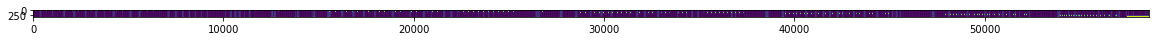

In [111]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

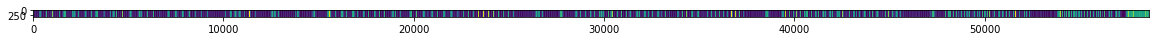

In [112]:
# all
plt.figure(figsize = figsize)
plt.imshow((xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

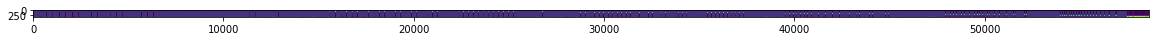

In [113]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [114]:
Counter(list((xy/xyind).reshape(-1))).most_common()

[(0.9999999999999999, 6519744),
 (1.0, 4926852),
 (8.319464999999999e-94, 2794176),
 (8.319465000000001e-94, 2127384),
 (0.9999999999999998, 1222452),
 (8.319464999999996e-94, 523908),
 (6.999999999999998, 465696),
 (4.4797119230769163e-94, 399168),
 (7.0, 354564),
 (4.479711923076917e-94, 301644),
 (3.7692307692307634, 144144),
 (3.769230769230764, 108927),
 (6.999999999999997, 87318),
 (4.479711923076916e-94, 74844),
 (1.0000000000000002, 37044),
 (3.769230769230763, 27027),
 (4.4797119230769173e-94, 2268),
 (3.7692307692307643, 819)]

([<matplotlib.axis.XTick at 0x7fabf15629a0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
 

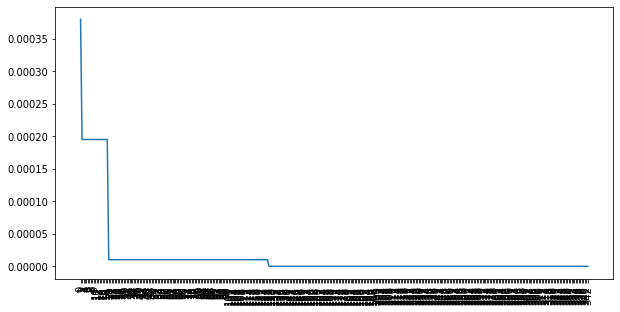

In [115]:
u,s,vh = np.linalg.svd(xy, full_matrices=True, compute_uv=True, hermitian=False)

plt.figure(figsize=(10,5))
plt.plot(s)
plt.xticks(ticks=np.arange(s.shape[0]), rotation='vertical')